In [1]:
pip install torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EarlyExitNN(nn.Module):
    def __init__(self, input_size=10, hidden_size=32, output_size=2, exit_threshold=0.90):
        super(EarlyExitNN, self).__init__()

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)  # First hidden layer
        self.fc2 = nn.Linear(hidden_size, hidden_size) # Second hidden layer
        self.fc3 = nn.Linear(hidden_size, output_size) # Final output layer

        # Early exit classifier (placed after second layer)
        self.exit_layer = nn.Linear(hidden_size, output_size)

        self.exit_threshold = exit_threshold  # Confidence threshold for early exit

    def forward(self, x):
        # First hidden layer
        x = F.relu(self.fc1(x))

        # Second hidden layer
        x = F.relu(self.fc2(x))

        # Compute early exit prediction
        early_output = F.softmax(self.exit_layer(x), dim=1)
        max_confidence, _ = torch.max(early_output, dim=1)

        # If confidence is high enough, return early output
        if torch.any(max_confidence > self.exit_threshold):
            return early_output

        # Otherwise, continue to full network
        final_output = self.fc3(x)
        return F.softmax(final_output, dim=1)

# Instantiate model
model = EarlyExitNN()


In [4]:
# Simulate input data (batch of 5 samples, each with 10 features)
x_test = torch.randn(5, 10)

# Get predictions
predictions = model(x_test)

print("Model Predictions:")
print(predictions)


Model Predictions:
tensor([[0.5114, 0.4886],
        [0.4725, 0.5275],
        [0.4814, 0.5186],
        [0.4807, 0.5193],
        [0.4481, 0.5519]], grad_fn=<SoftmaxBackward0>)


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.50MB/s]


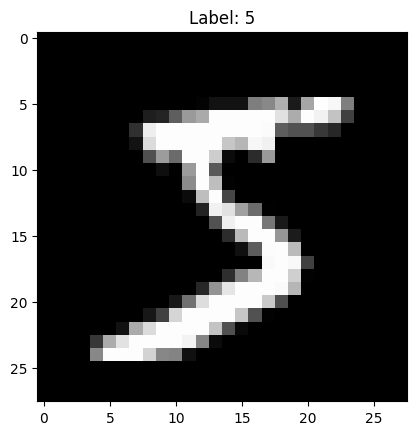

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Show a sample image
plt.imshow(trainset.data[0], cmap="gray")
plt.title(f"Label: {trainset.targets[0]}")
plt.show()


In [6]:
class EarlyExitMNIST(nn.Module):
    def __init__(self, exit_threshold=0.90):
        super(EarlyExitMNIST, self).__init__()

        self.fc1 = nn.Linear(28 * 28, 128)  # First hidden layer
        self.fc2 = nn.Linear(128, 64)       # Second hidden layer
        self.fc3 = nn.Linear(64, 10)        # Final layer (10 classes)

        # Early exit classifier after second layer
        self.exit_layer = nn.Linear(64, 10)

        self.exit_threshold = exit_threshold  # Confidence threshold for early exit

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the 28x28 image

        x = F.relu(self.fc1(x))  # First layer
        x = F.relu(self.fc2(x))  # Second layer

        # Compute early exit prediction
        early_output = F.softmax(self.exit_layer(x), dim=1)
        max_confidence, predicted_label = torch.max(early_output, dim=1)

        # If confidence is high, exit early
        if torch.any(max_confidence > self.exit_threshold):
            return early_output, True  # Returning True indicates early exit

        # Otherwise, continue to full network
        final_output = self.fc3(x)
        return F.softmax(final_output, dim=1), False

# Instantiate model
model = EarlyExitMNIST()


In [8]:
def train_model(model, trainloader, epochs=10, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            optimizer.zero_grad()

            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader)}")

# Train the model
train_model(model, trainloader)


Epoch 1/10, Loss: 1.5979673671824084
Epoch 2/10, Loss: 1.5221604454491946
Epoch 3/10, Loss: 1.5123236436071172
Epoch 4/10, Loss: 1.5064552270018978
Epoch 5/10, Loss: 1.5047794399993506
Epoch 6/10, Loss: 1.5015055791401406
Epoch 7/10, Loss: 1.4997229290161052
Epoch 8/10, Loss: 1.4971064022863343
Epoch 9/10, Loss: 1.495573551924244
Epoch 10/10, Loss: 1.4953765292157497


In [9]:
def test_model(model, testloader):
    correct = 0
    total = 0
    early_exit_count = 0

    with torch.no_grad():
        for images, labels in testloader:
            outputs, exited_early = model(images)
            _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            if exited_early:
                early_exit_count += 1

    print(f"Accuracy: {100 * correct / total:.2f}%")
    print(f"Early Exits: {early_exit_count}/{len(testloader)} batches exited early")

# Test the model
test_model(model, testloader)


Accuracy: 96.18%
Early Exits: 157/157 batches exited early


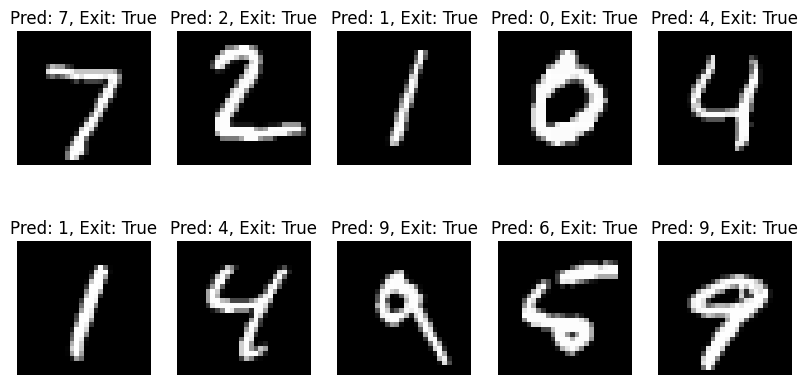

In [10]:
def visualize_early_exits(model, testloader, num_samples=10):
    model.eval()
    samples_shown = 0

    plt.figure(figsize=(10, 5))

    with torch.no_grad():
        for images, labels in testloader:
            for i in range(images.shape[0]):
                if samples_shown >= num_samples:
                    return

                outputs, exited_early = model(images[i].unsqueeze(0))
                _, predicted = torch.max(outputs, 1)

                plt.subplot(2, 5, samples_shown + 1)
                plt.imshow(images[i].squeeze(), cmap="gray")
                plt.title(f"Pred: {predicted.item()}, Exit: {exited_early}")
                plt.axis('off')

                samples_shown += 1

# Show images with early exits
visualize_early_exits(model, testloader)
